# Import CIVET data from txt files
* **Objectives:** 
    1. Cluster CIVET vertices into ROIs (based on an atlas)
    2. Generate ROI/Subject based distributions to find outlier

* **Atlases:** 
    1. AAL
    2. Spect_cluster

In [1]:
# Basic Imports
import numpy as np
#import h5py as h5
from sklearn.externals import joblib
import collections
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.cross_validation import KFold
import pickle
import re
import os
import os.path
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from collections import Counter
%matplotlib inline

/projects/nbhagwat/ADNI_prediction/code/conda_envs/AD_traj_hopper/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Some defs

# filter CT columns and compute stats
def get_ct_data(df_data,qc_list,cleanup_names):        
    #drop QC fails    
    if cleanup_names:
        std_list = []
        for f in qc_list:
            filename = f.split('_', 1)[1]
            filename = filename.rsplit('_', 1)[0]
            std_list.append(filename)

        qc_list = std_list
    
    df_data = df_data[df_data['filename'].isin(qc_list)]
    print 'QC passed scans: {}'.format(len(df_data))
    
    ct_cols = ['filename'] + list(df_data.columns[pd.Series(df_data.columns).str.contains('CT')])
    ct_data = df_data[ct_cols]
    
    #find NaNs
    nan_subs = ct_data[ct_data.isnull().any(axis=1)].index
    print '{} NaN subjects found'.format(len(nan_subs))
    print nan_subs
    
    #drop NaNs
    ct_data.dropna(inplace=True)
    
    #append ImageUID col
    iid_list = []
    for f in ct_data['filename'].values:        
        iid = f.rsplit('_', 1)[1]
        iid = iid.split('I')[1]
        iid_list.append(int(iid))

    ct_data['ImageUID'] = iid_list

    #Summary Stats
    return ct_data

#Statistical test to check if two cohorts have similar distibutions 
def get_significance(df1,df2,cols):
    t_vals = []
    p_vals = []

    for col in cols:
        a = df1[col].values
        b = df2[col].values
        t_vals.append(ttest_ind(a,b)[0])
        p_vals.append(ttest_ind(a,b)[1])

    ttest_df = pd.DataFrame(columns=['ct_roi','t_val','p_val'])
    ttest_df['ct_roi'] = cols
    ttest_df['t_val'] = t_vals
    ttest_df['p_val'] = p_vals
    
    return ttest_df

# Tag outliers
def tag_outliers(df,thresold,max_outlier_roi_count,max_outlier_sub_count):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = (df < (Q1 - thresold*IQR)) | (df > (Q3 + thresold*IQR))
    
    print 'Subjects with most frequent outlier values'
    df_outliers = pd.DataFrame(outlier_mask.sum(1),columns=['outlier_roi_count'])
    outlier_subs = df_outliers[df_outliers['outlier_roi_count'] > max_outlier_roi_count].sort_values(by='outlier_roi_count',ascending=False)
    print outlier_subs
    print ''
    
    print 'ROIs with most frequet outlier values'
    df_outliers = pd.DataFrame(outlier_mask.sum(0),columns=['outlier_sub_count'])
    outlier_rois = df_outliers[df_outliers['outlier_sub_count'] > max_outlier_sub_count].sort_values(by='outlier_sub_count',ascending=False)  
    print outlier_rois
    
    return list(outlier_subs.index),list(outlier_rois.index)


In [3]:
# Paths
baseline_dir = '/projects/nbhagwat/datasets/'
adni1_1_5_aal_csv_3yr = '{}ADNI1_1_5/adni1_1_5_civet_aal.csv'.format(baseline_dir)
adni1_1_5_aal_csv_1yr = '{}ADNI1_1_5/adni1_1_5_civet_aal_1yr.csv'.format(baseline_dir)
adni1_1_5_qc_csv_3yr = '{}ADNI1_1_5/ADNI1_1.5T_QC.csv'.format(baseline_dir)
adni1_1_5_qc_csv_1yr = '{}ADNI1_1_5/ADNI1_1.5T_QC_1yr.csv'.format(baseline_dir)

adni1_qc_csv_mallar = '/projects/nbhagwat/datasets/ADNI_1_QC_mallar_April25.csv'

adni2_aal_csv = '{}ADNI2/adni2_civet_aal.csv'.format(baseline_dir)
adni2_qc_csv = '{}ADNI2/adni2_civet_qc.csv'.format(baseline_dir)
adni2_qc_csv_mallar = '/projects/nbhagwat/datasets/ADNI_2_QC_mallar_April25.csv'

In [31]:
# read data
# adni1_1_5
print 'dataset: ADNI1_3Yr'

df_aal_data = pd.read_csv(adni1_1_5_aal_csv_3yr)
df_qc = pd.read_csv(adni1_1_5_qc_csv_3yr)

cleanup_names = True

print 'data_total: {}, qc_total: {}, #0:{}, #0.5:{}, #1:{}'.format(len(df_aal_data),len(df_qc),
                                                                 len(df_qc[df_qc['score']==0.0]),
                                                                 len(df_qc[df_qc['score']==0.5]),
                                                                 len(df_qc[df_qc['score']==1]))
adni1_1_5_ct_data_3yr = get_ct_data(df_aal_data,df_qc[df_qc['score']!=0]['filename'].values,cleanup_names)
adni1_1_5_ct_data_3yr_strictQC = get_ct_data(df_aal_data,df_qc[df_qc['score']==1]['filename'].values,cleanup_names)

print 'dataset: ADNI1_1Yr'
df_aal_data = pd.read_csv(adni1_1_5_aal_csv_1yr)
df_qc = pd.read_csv(adni1_1_5_qc_csv_1yr)

cleanup_names = False

print 'data_total: {}, qc_total: {}, #0:{}, #0.5:{}, #1:{}'.format(len(df_aal_data),len(df_qc),
                                                                 len(df_qc[df_qc['score']==0.0]),
                                                                 len(df_qc[df_qc['score']==0.5]),
                                                                 len(df_qc[df_qc['score']==1]))
adni1_1_5_ct_data_1yr = get_ct_data(df_aal_data,df_qc[df_qc['score']!=0]['filename'].values,cleanup_names)
adni1_1_5_ct_data_1yr_strictQC = get_ct_data(df_aal_data,df_qc[df_qc['score']==1]['filename'].values,cleanup_names)


# merge the two adni1 datasets (3yr + 1yr)
adni1_1_5_ct_data = pd.concat([adni1_1_5_ct_data_3yr,adni1_1_5_ct_data_1yr])
adni1_1_5_ct_data_strictQC = pd.concat([adni1_1_5_ct_data_3yr_strictQC,adni1_1_5_ct_data_1yr_strictQC])

# adni2
df_aal_data = pd.read_csv(adni2_aal_csv)
df_qc = pd.read_csv(adni2_qc_csv)
cleanup_names = False
print 'dataset: ADNI2'
print 'data_total: {}, qc_total: {}, #0:{}, #0.5:{}, #1:{}'.format(len(df_aal_data),len(df_qc),
                                                                 len(df_qc[df_qc['score']==0.0]),
                                                                 len(df_qc[df_qc['score']==0.5]),
                                                                 len(df_qc[df_qc['score']==1]))
adni2_ct_data = get_ct_data(df_aal_data,df_qc[df_qc['score']!=0]['filename'].values,cleanup_names)
adni2_ct_data_strictQC = get_ct_data(df_aal_data,df_qc[df_qc['score']==1]['filename'].values,cleanup_names)

dataset: ADNI1_3Yr
data_total: 2182, qc_total: 2182, #0:260, #0.5:1132, #1:790
QC passed scans: 1922
0 NaN subjects found
Int64Index([], dtype='int64')


/mnt/tigrlab/projects/nbhagwat/ADNI_prediction/code/conda_envs/AD_traj_hopper/lib/python2.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/tigrlab/projects/nbhagwat/ADNI_prediction/code/conda_envs/AD_traj_hopper/lib/python2.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


QC passed scans: 790
0 NaN subjects found
Int64Index([], dtype='int64')
dataset: ADNI1_1Yr
data_total: 949, qc_total: 949, #0:59, #0.5:135, #1:755
QC passed scans: 890
0 NaN subjects found
Int64Index([], dtype='int64')
QC passed scans: 755
0 NaN subjects found
Int64Index([], dtype='int64')
dataset: ADNI2
data_total: 1310, qc_total: 1310, #0:140, #0.5:54, #1:1116
QC passed scans: 1170
0 NaN subjects found
Int64Index([], dtype='int64')
QC passed scans: 1116
0 NaN subjects found
Int64Index([], dtype='int64')


In [60]:
#Compare QC from Mallar 

## ADNI1
df_qc = pd.read_csv(adni1_1_5_qc_csv)
df_qc_mallar = pd.read_csv(adni1_qc_csv_mallar)

## ADNI2
# df_qc = pd.read_csv(adni2_qc_csv)
# df_qc['filename'] = 'adni2_'+ (df_qc.filename.values) + '_verify'
# df_qc_mallar = pd.read_csv(adni2_qc_csv_mallar)

print len(df_qc),len(df_qc_mallar)

qc_compare_df = pd.merge(df_qc,df_qc_mallar,on='filename',how='inner')
print len(qc_compare_df)
print np.sum(qc_compare_df.score.values==qc_compare_df.score_mallar.values)

# 256
# 233
print 233/256.0

2182 228
181
76
0.91015625


In [32]:
# import Dx labels
adnimerge_file = '/projects/nbhagwat/datasets/adni_tables_April2017/ADNIMERGE_ImageUID_April2017.csv'
adnimerge_data = pd.read_csv(adnimerge_file)
demo_cols = ['PTID','ADAS13','ADAS11','DX_bl','DX','ORIGPROT','COLPROT','MMSE','AGE','PTGENDER', 'APOE4',
             'ImageUID','VISCODE','EXAMDATE','MagStrength']
in_data = adnimerge_data[demo_cols]
#add a column with numerical DX mapping
in_data['DX_cat'] = in_data['DX_bl'].replace(['MCI to NL', 'CN','NL','SMC'], 0)
in_data['DX_cat'] = in_data['DX_cat'].replace(['NL to MCI', 'EMCI','LMCI','MCI', 'Dementia to MCI'], 1)
in_data['DX_cat'] = in_data['DX_cat'].replace(['AD','NL to Dementia','MCI to Dementia', 'Dementia'], 2)
in_data['DX_cat'].values.astype(float)

/mnt/tigrlab/projects/nbhagwat/ADNI_prediction/code/conda_envs/AD_traj_hopper/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/mnt/tigrlab/projects/nbhagwat/ADNI_prediction/code/conda_envs/AD_traj_hopper/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/mnt/tigrlab/projects/nbhagwat/ADNI_prediction/code/conda_envs/AD_traj_hopper/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value

array([ 0.,  0.,  0., ...,  1.,  1.,  1.])

In [33]:
# Merge CT data with ADNIMERGE using ImageUIDs
print 'Lenient QC'
print 'scans before merge (scans:adni1,adni2,adnimerge):{},{},{}'.format(len(adni1_1_5_ct_data), len(adni2_ct_data), len(in_data))
adni1_1_5_ct_data = pd.merge(adni1_1_5_ct_data,in_data,on='ImageUID',how='inner')
adni2_ct_data = pd.merge(adni2_ct_data,in_data,on='ImageUID',how='inner')
print 'scans after merge (scans:adni1,adni2):{},{}'.format(len(adni1_1_5_ct_data), len(adni2_ct_data))

#Strict QC
print 'Strict QC'
print 'scans before merge (scans:adni1,adni2,adnimerge):{},{},{}'.format(len(adni1_1_5_ct_data_strictQC), len(adni2_ct_data_strictQC), len(in_data))
adni1_1_5_ct_data_strictQC = pd.merge(adni1_1_5_ct_data_strictQC,in_data,on='ImageUID',how='inner')
adni2_ct_data_strictQC = pd.merge(adni2_ct_data_strictQC,in_data,on='ImageUID',how='inner')
print 'scans after merge (scans:adni1,adni2):{},{}'.format(len(adni1_1_5_ct_data_strictQC), len(adni2_ct_data_strictQC))

ct_cols = list(adni2_ct_data.columns[pd.Series(adni2_ct_data.columns).str.contains('CT')])

####Check for not found CT scans in the ADNIMERGE_ImageID dataframe
# not_found = set(adni2_ct_data.ImageUID.values) - set(in_data.ImageUID.values)
# not_found_scans = adni2_ct_data[adni2_ct_data.ImageUID.isin(not_found)].filename.values
# not_found_scans

Lenient QC
scans before merge (scans:adni1,adni2,adnimerge):2812,1170,34402
scans after merge (scans:adni1,adni2):2808,1167
Strict QC
scans before merge (scans:adni1,adni2,adnimerge):1545,1116,34402
scans after merge (scans:adni1,adni2):1542,1113


In [34]:
len(set(adni1_1_5_ct_data.PTID.values))

607

In [63]:
# Tag outliers
max_outlier_roi_count = 30
max_outlier_sub_count = 30

#ADNI1
print 'adni1 quantitative outliers'
outlier_subs,outlier_rois = tag_outliers(adni1_1_5_ct_data[ct_cols],1.5,max_outlier_roi_count,max_outlier_sub_count)
print adni1_1_5_ct_data.loc[outlier_subs,'filename'].values

#drop the outlier rows
print 'subx before outlier drop: {}'.format(len(adni1_1_5_ct_data))
adni1_1_5_ct_data.drop(adni1_1_5_ct_data.index[outlier_subs],inplace=True)
print 'subx after outlier drop: {}'.format(len(adni1_1_5_ct_data))

print ''

#ADNI2
print 'adni2 quantitative outliers'
outlier_subs,outlier_rois = tag_outliers(adni2_ct_data[ct_cols],1.5,max_outlier_roi_count,max_outlier_sub_count)
print adni2_ct_data.loc[outlier_subs,'filename'].values

#drop the outlier rows
print 'subx before outlier drop: {}'.format(len(adni2_ct_data))
adni2_ct_data.drop(adni2_ct_data.index[outlier_subs],inplace=True)
print 'subx after outlier drop: {}'.format(len(adni2_ct_data))

adni1 quantitative outliers
Subjects with most frequent outlier values
Empty DataFrame
Columns: [outlier_roi_count]
Index: []

ROIs with most frequet outlier values
                outlier_sub_count
PCL.R_CT                      119
PCL.L_CT                       87
CUN.L_CT                       65
TPOmid.R_CT                    51
SOG.L_CT                       48
PCG.L_CT                       45
ORBsupmed.L_CT                 43
ITG.L_CT                       43
SPG.L_CT                       43
PoCG.R_CT                      42
LING.L_CT                      42
MTG.L_CT                       41
PoCG.L_CT                      38
ROL.R_CT                       38
FFG.L_CT                       37
ACG.R_CT                       36
SFGmed.L_CT                    35
ITG.R_CT                       34
ORBsup.R_CT                    34
PCG.R_CT                       33
ORBsup.L_CT                    33
TPOsup.R_CT                    32
CUN.R_CT                       31
OLF.R_CT           

ct_data_1 dx:0, subx:869
ct_data_2 dx:0, subx:445
ct_data_1 dx:1, subx:1429
ct_data_2 dx:1, subx:844
ct_data_1 dx:2, subx:507
ct_data_2 dx:2, subx:253


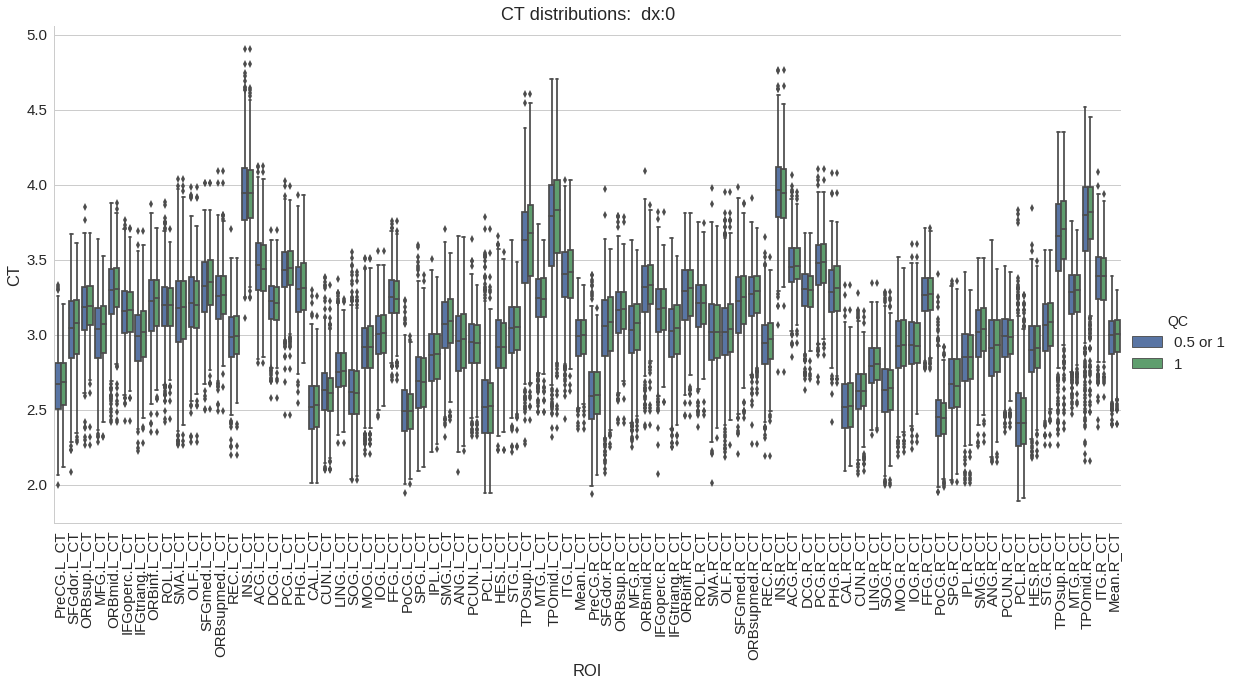

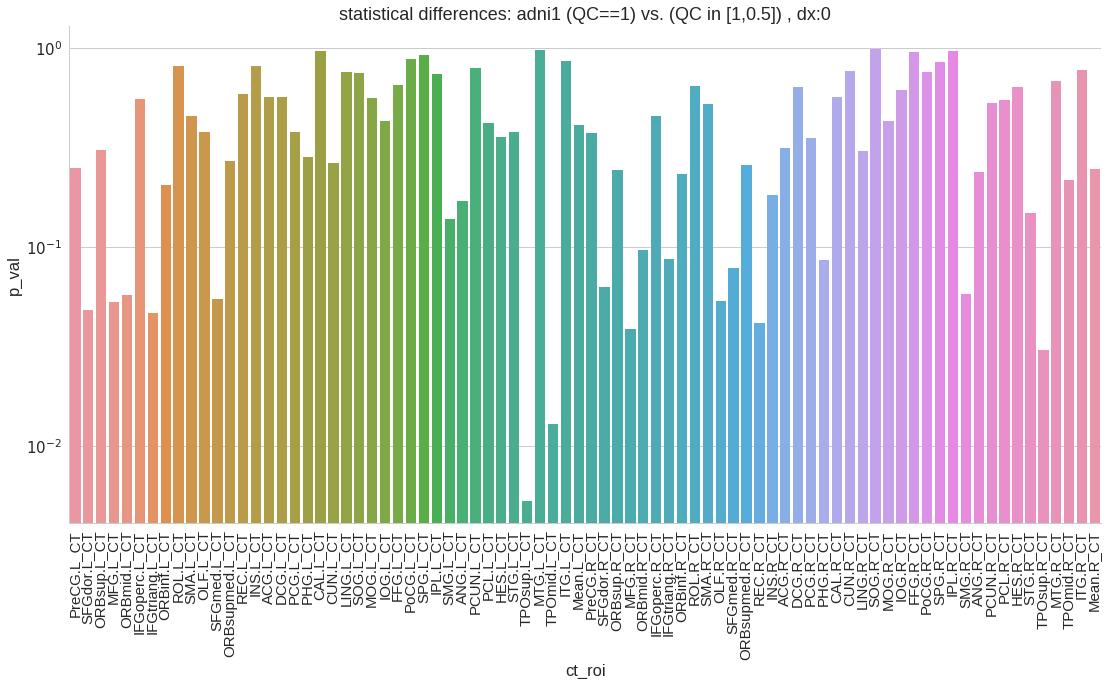

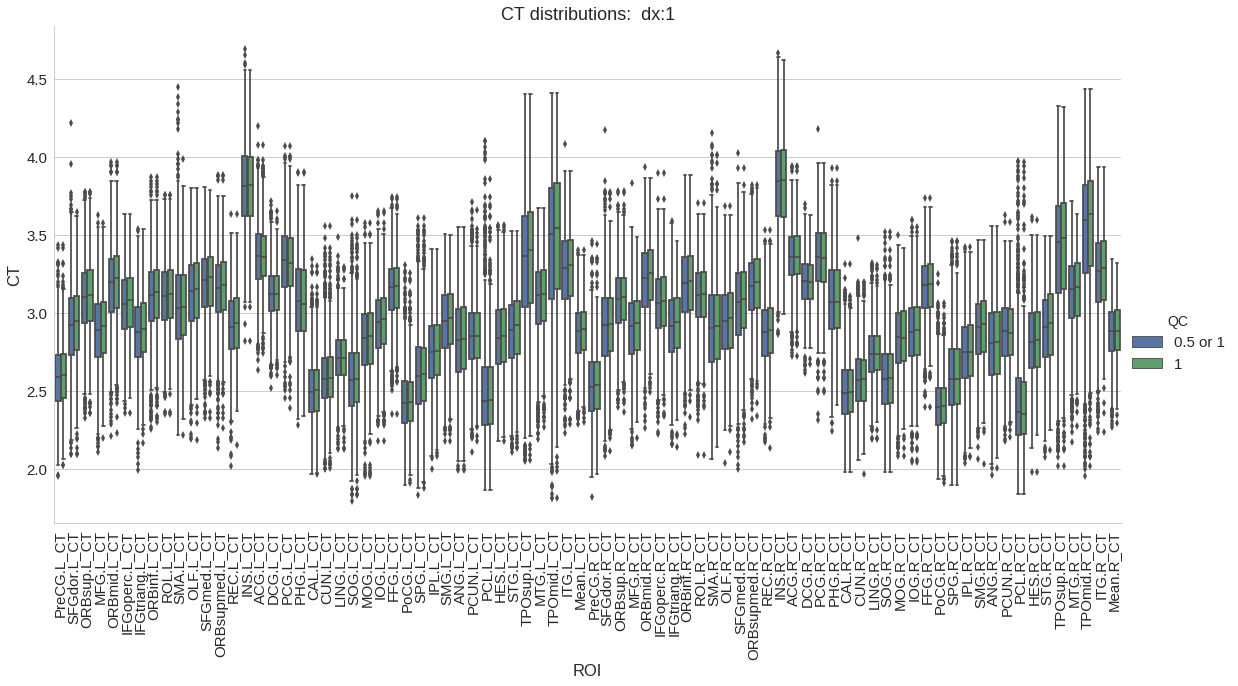

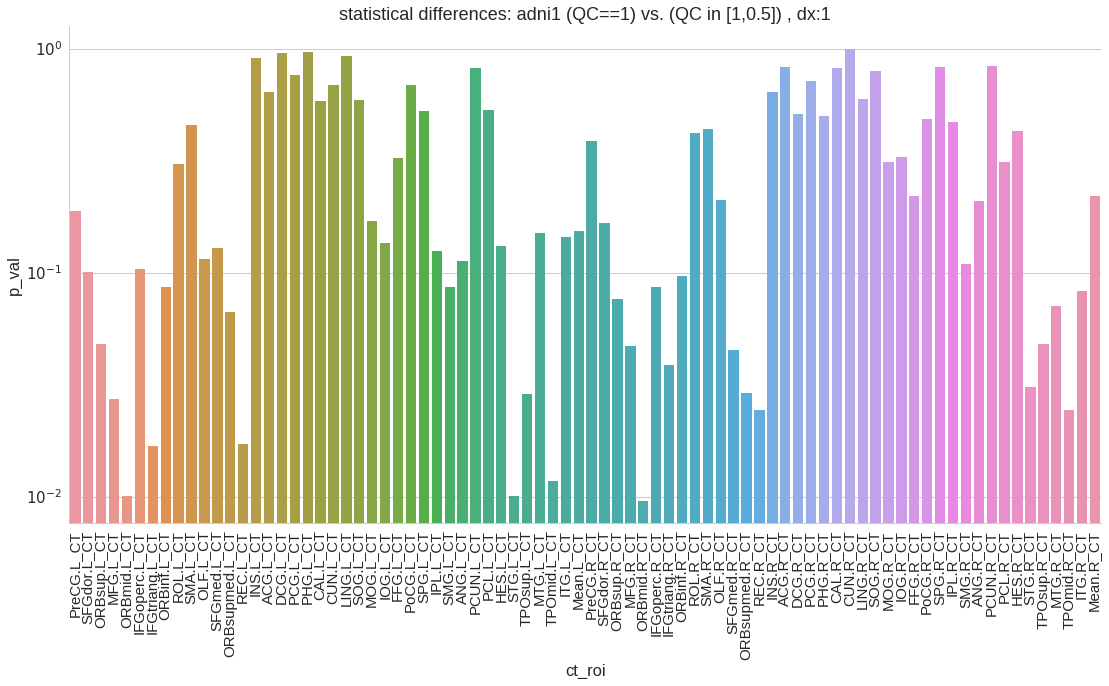

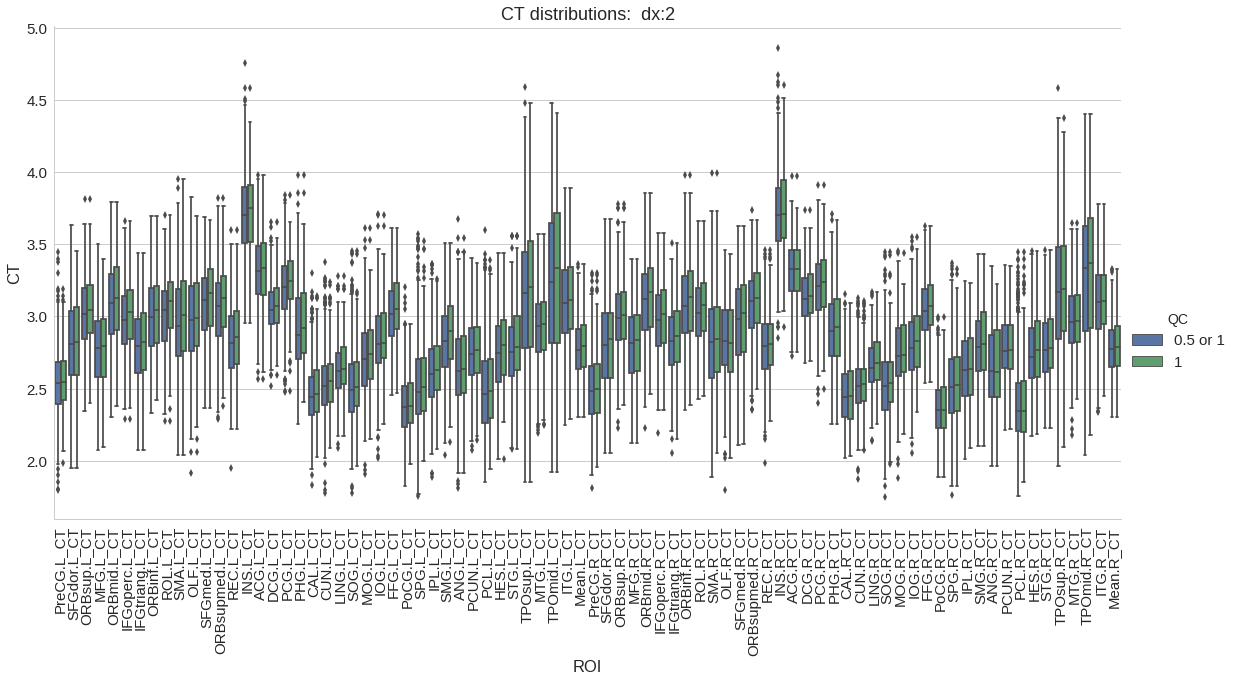

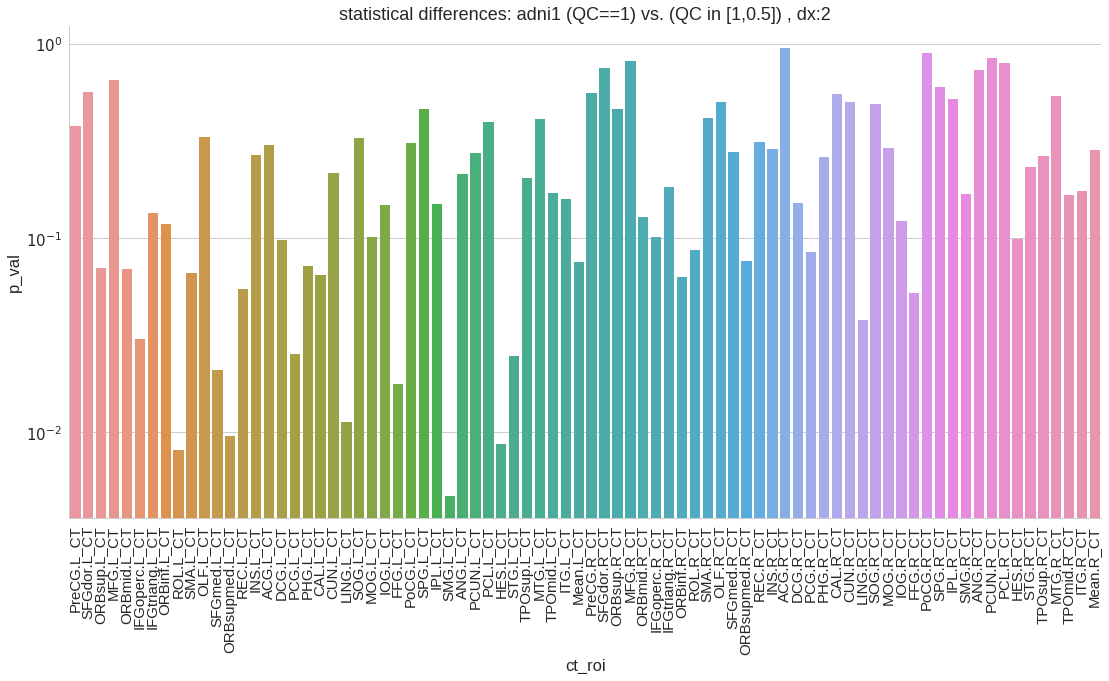

In [38]:
# Plots
# Check effect of QC (grouped by Dx)

plt.rcParams['figure.figsize'] = (20, 20)
sns.set(font_scale=1.5) 

for dx in [0,1,2]:    
    #Lenient QC
    ct_data_1 = adni1_1_5_ct_data[adni1_1_5_ct_data.DX_cat==dx][['ImageUID'] + ct_cols]
    #ct_data_1 = adni2_ct_data[adni2_ct_data.DX_cat==dx][['ImageUID'] + ct_cols]
    ct_data_1_melt = pd.melt(ct_data_1,id_vars='ImageUID',value_vars=ct_cols,var_name='ROI', value_name='CT')
    ct_data_1_melt['QC'] = list(np.tile('0.5 or 1', len(ct_data_1_melt)))
    print 'ct_data_1 dx:{}, subx:{}'.format(dx,len(ct_data_1))
    
    #Strict QC
    ct_data_2 = adni1_1_5_ct_data_strictQC[adni1_1_5_ct_data_strictQC.DX_cat==dx][['ImageUID'] + ct_cols]
    #ct_data_2 = adni2_ct_data_strictQC[adni2_ct_data_strictQC.DX_cat==dx][['ImageUID'] + ct_cols]
    ct_data_2_melt = pd.melt(ct_data_2,id_vars='ImageUID',value_vars=ct_cols,var_name='ROI', value_name='CT')
    ct_data_2_melt['QC'] = list(np.tile('1', len(ct_data_2_melt)))
    print 'ct_data_2 dx:{}, subx:{}'.format(dx,len(ct_data_2))
    
    #concat ct_data_1 and ct_data_2
    ct_data_concat = pd.concat([ct_data_1_melt,ct_data_2_melt])
    
    #Distributions
    sns.set_style("whitegrid")    
    g1 = sns.factorplot(y='CT',x='ROI',kind='box', hue='QC', data=ct_data_concat,size=8, aspect=2)
    g1.set_xticklabels(rotation=90)   
    plt.title('CT distributions:  dx:{}'.format(dx))
    
    #Significance
    ttest_df = get_significance(ct_data_1,ct_data_2,ct_cols)    
    g3 = sns.factorplot(y='p_val',x='ct_roi',kind='bar',data=ttest_df,size=8, aspect=2)
    g3.set_xticklabels(rotation=90)
    g3.fig.get_axes()[0].set_yscale('log')    
    plt.title('statistical differences: adni1 (QC==1) vs. (QC in [1,0.5]) , dx:{}'.format(dx))


ct_data_1 dx:0, subx:869
ct_data_2 dx:0, subx:400
ct_data_1 dx:1, subx:1429
ct_data_2 dx:1, subx:585
ct_data_1 dx:2, subx:507
ct_data_2 dx:2, subx:180


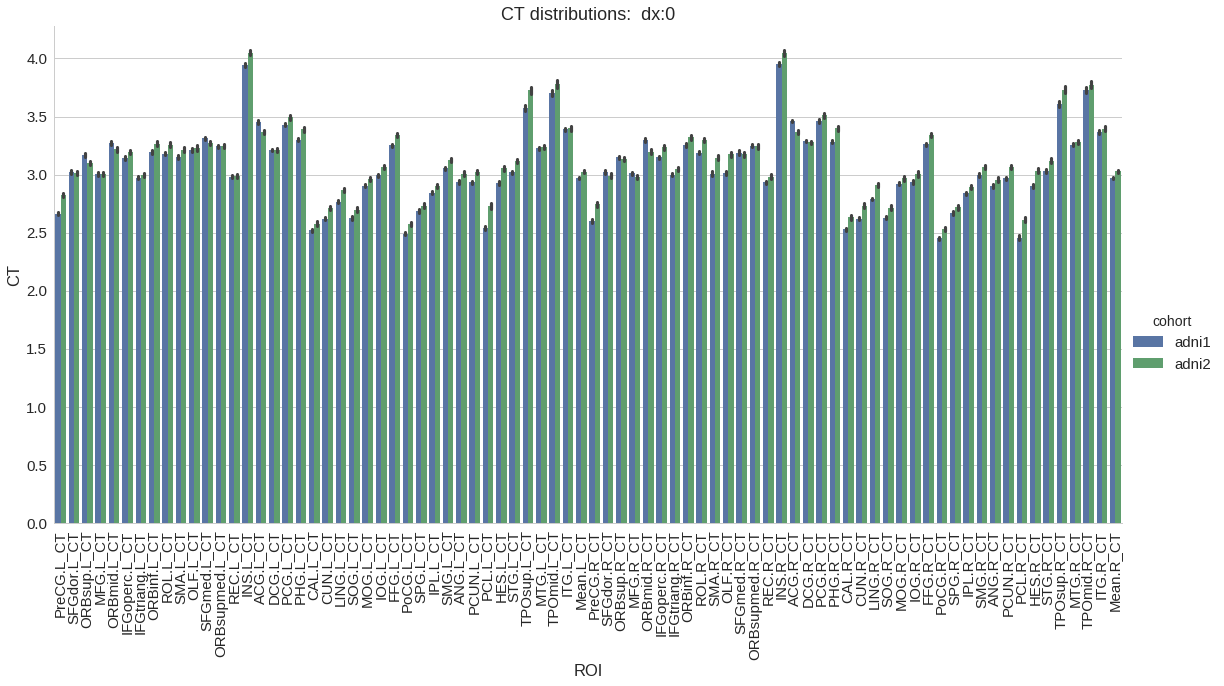

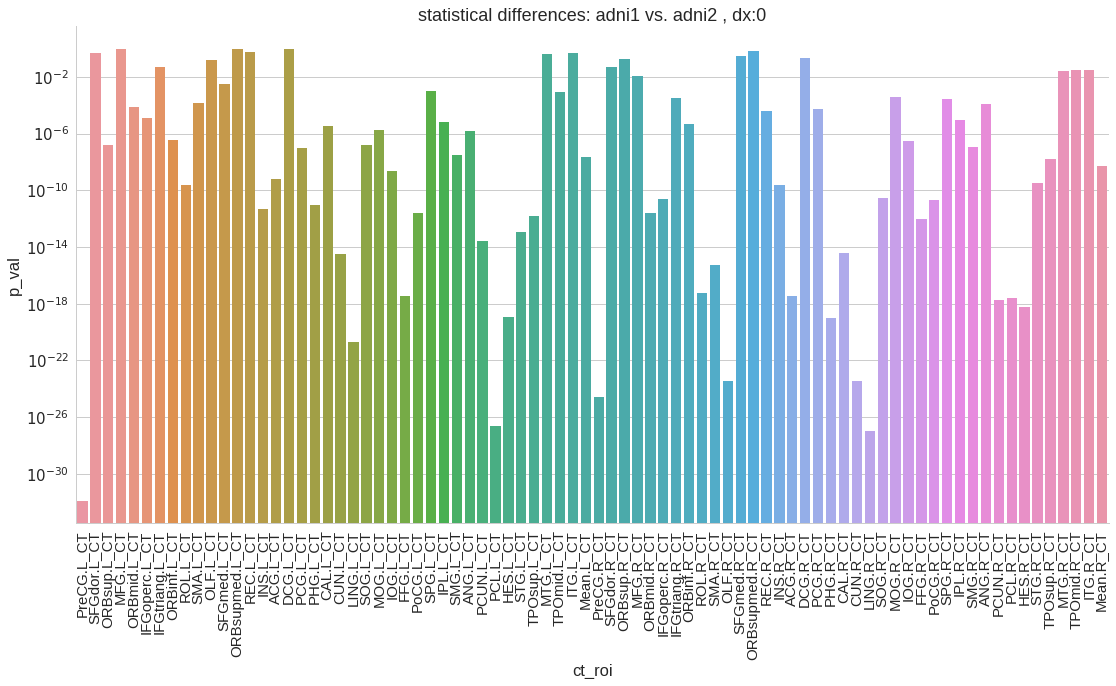

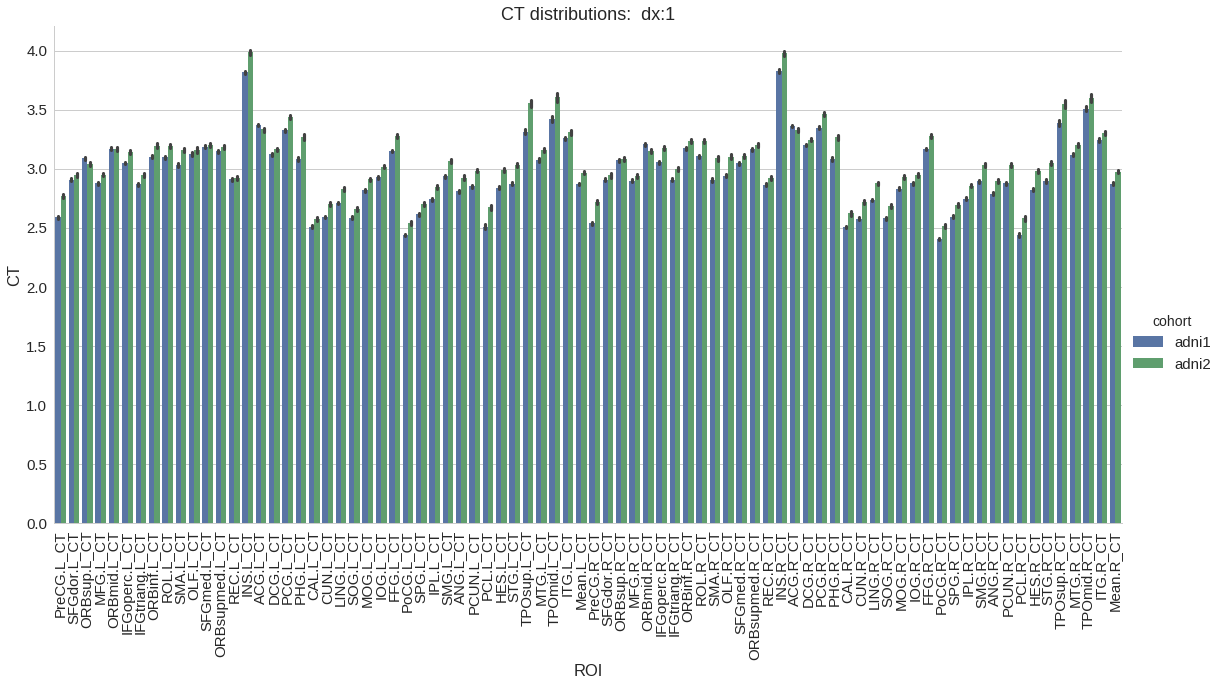

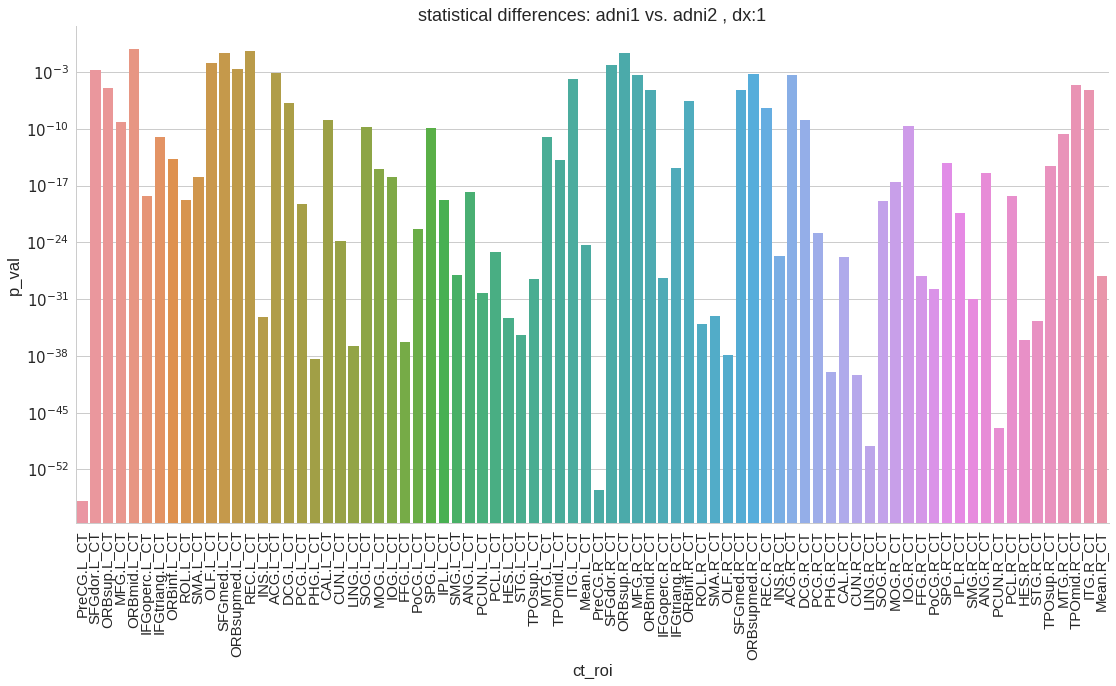

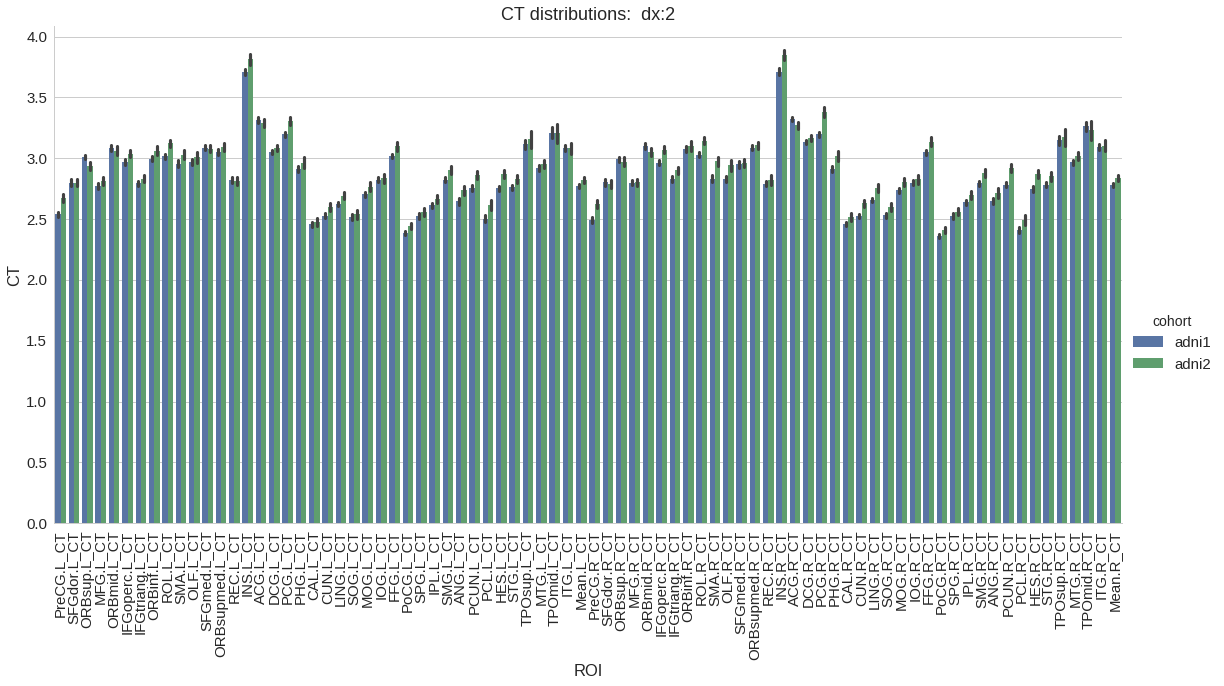

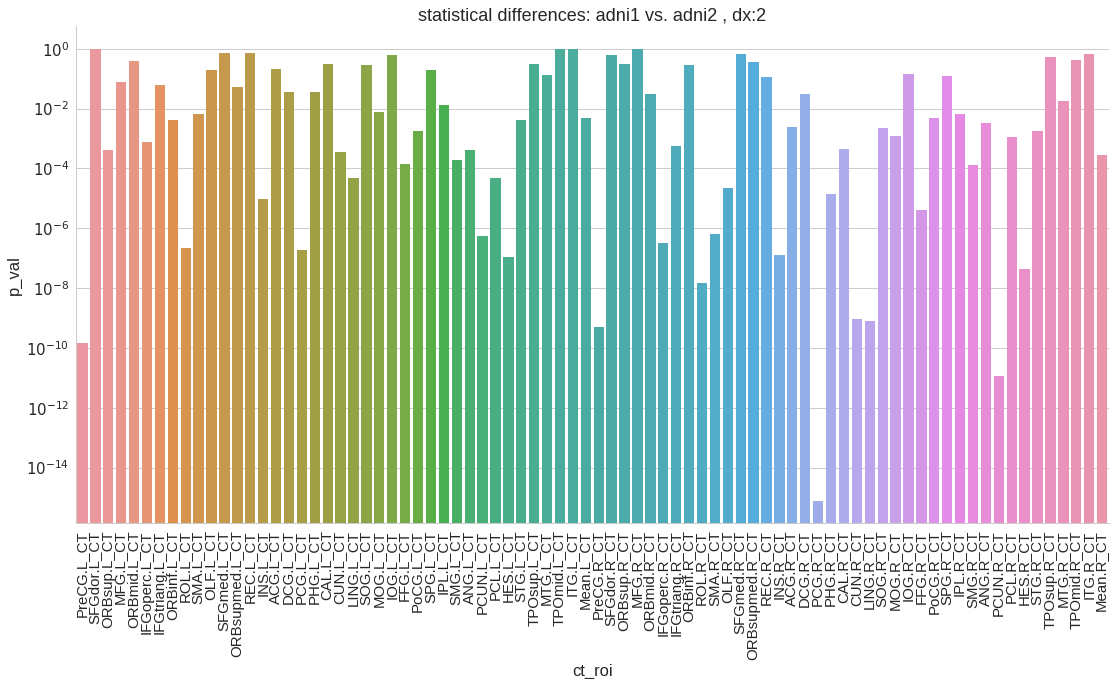

In [62]:
#Plots
#Check effect of cohorts (grouped by Dx)

plt.rcParams['figure.figsize'] = (20, 20)
sns.set(font_scale=1.5) 

for dx in [0,1,2]:    
    #ADNI1
    ct_data_1 = adni1_1_5_ct_data[adni1_1_5_ct_data.DX_cat==dx][['ImageUID'] + ct_cols]
    ct_data_1_melt = pd.melt(ct_data_1,id_vars='ImageUID',value_vars=ct_cols,var_name='ROI', value_name='CT')
    ct_data_1_melt['cohort'] = list(np.tile('adni1', len(ct_data_1_melt)))
    print 'ct_data_1 dx:{}, subx:{}'.format(dx,len(ct_data_1))
    
    #ADNI2
    ct_data_2 = adni2_ct_data[adni2_ct_data.DX_cat==dx][['ImageUID'] + ct_cols]
    ct_data_2_melt = pd.melt(ct_data_2,id_vars='ImageUID',value_vars=ct_cols,var_name='ROI', value_name='CT')
    ct_data_2_melt['cohort'] = list(np.tile('adni2', len(ct_data_2_melt)))
    print 'ct_data_2 dx:{}, subx:{}'.format(dx,len(ct_data_2))
    
    #concat ct_data_1 and ct_data_2
    ct_data_concat = pd.concat([ct_data_1_melt,ct_data_2_melt])
    
    #Distributions
    sns.set_style("whitegrid")    
    g1 = sns.factorplot(y='CT',x='ROI',kind='bar', hue='cohort', data=ct_data_concat,size=8, aspect=2)
    g1.set_xticklabels(rotation=90)   
    plt.title('CT distributions:  dx:{}'.format(dx))
    
    #Significance
    ttest_df = get_significance(ct_data_1,ct_data_2,ct_cols)    
    g3 = sns.factorplot(y='p_val',x='ct_roi',kind='bar',data=ttest_df,size=8, aspect=2)
    g3.set_xticklabels(rotation=90)
    g3.fig.get_axes()[0].set_yscale('log')    
    plt.title('statistical differences: adni1 vs. adni2 , dx:{}'.format(dx))

In [194]:
adni2_ct_data.describe()

,PreCG.L_CT,SFGdor.L_CT,ORBsup.L_CT,MFG.L_CT,ORBmid.L_CT,IFGoperc.L_CT,IFGtriang.L_CT,ORBinf.L_CT,ROL.L_CT,SMA.L_CT,...,TPOsup.R_CT,MTG.R_CT,TPOmid.R_CT,ITG.R_CT,Mean.R_CT,ImageUID,ADAS13,ADAS11,MMSE,DX_cat
count,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,...,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,900.000000,901.000000,916.000000,1115.000000
mean,2.779386,2.950307,3.046730,2.951123,3.172042,3.147406,2.950820,3.202426,3.210238,3.158583,...,3.556001,3.202589,3.607307,3.307612,2.974772,351147.753363,16.788889,11.206437,26.274017,0.810762
std,0.212363,0.223540,0.208415,0.195819,0.215621,0.197209,0.191854,0.234451,0.197813,0.236946,...,0.432817,0.232221,0.445570,0.269163,0.174306,60706.118518,14.094544,10.572585,4.994885,0.685232
min,2.120100,2.009400,2.334100,2.125400,2.396700,2.290400,2.324600,2.427400,2.488400,2.336900,...,1.846600,2.272700,1.881600,2.348300,2.357000,228524.000000,0.000000,0.000000,0.000000,0.000000
25%,2.641500,2.801650,2.916650,2.817600,3.040050,3.021200,2.835850,3.053400,3.079250,3.016350,...,3.330950,3.079850,3.382000,3.151650,2.867150,293747.000000,7.000000,5.000000,25.000000,0.000000
50%,2.777400,2.975300,3.050100,2.968400,3.171700,3.164000,2.969700,3.222500,3.215900,3.179400,...,3.645300,3.242300,3.703100,3.340400,2.999700,351996.000000,13.000000,8.000000,28.000000,1.000000
75%,2.934800,3.102350,3.178500,3.086700,3.315000,3.286900,3.082100,3.362300,3.357000,3.306750,...,3.861750,3.366000,3.918100,3.484900,3.097500,413730.000000,22.250000,15.000000,29.000000,1.000000
max,3.352700,3.637900,3.813500,3.563000,4.058300,3.712700,3.502500,3.936000,3.812900,3.998300,...,4.474900,3.789600,4.514800,3.990600,3.433500,451521.000000,85.000000,70.000000,30.000000,2.000000


* **Import Previous CIVET Data:** 
    1. Note: It has a few ADNI1 and ADNI2 subjects which need to parsed out

In [36]:
#Paths
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/longitudinal_trajectories/input_csv/'
prev_ct_file = 'ADNI2_subject_ROI_CT_dict_AAL.csv'
prev_ct_data = pd.read_csv(baseline_dir + prev_ct_file)

#old ct roi naming
ct_feat = ['AAL_1', 'AAL_2', 'AAL_3','AAL_4', 'AAL_5', 'AAL_6', 'AAL_7', 'AAL_8', 'AAL_9', 'AAL_10',
                 'AAL_11', 'AAL_12', 'AAL_13', 'AAL_14', 'AAL_15', 'AAL_16', 'AAL_17', 'AAL_18', 'AAL_19', 'AAL_20', 
                 'AAL_21', 'AAL_22', 'AAL_23', 'AAL_24', 'AAL_25', 'AAL_26', 'AAL_27', 'AAL_28', 'AAL_29', 'AAL_30', 
                 'AAL_31', 'AAL_32', 'AAL_33', 'AAL_34', 'AAL_35', 'AAL_36', 'AAL_39', 'AAL_40', 'AAL_43', 'AAL_44', 
                 'AAL_45', 'AAL_46', 'AAL_47', 'AAL_48', 'AAL_49', 'AAL_50', 'AAL_51', 'AAL_52', 'AAL_53', 'AAL_54',
                 'AAL_55', 'AAL_56', 'AAL_57', 'AAL_58', 'AAL_59', 'AAL_60', 'AAL_61', 'AAL_62', 'AAL_63', 'AAL_64', 
                 'AAL_65', 'AAL_66', 'AAL_67', 'AAL_68', 'AAL_69', 'AAL_70', 'AAL_79', 'AAL_80', 'AAL_81', 'AAL_82',
                 'AAL_83', 'AAL_84', 'AAL_85', 'AAL_86', 'AAL_87', 'AAL_88', 'AAL_89', 'AAL_90']

# Rename columns to be consistent with new CIVET csv
AAL_rois = '/projects/nikhil/ADNI_prediction/input_datasets/CT/AAL/AAL_README_roi_names'
aal_rois_df = pd.read_csv(AAL_rois,delimiter='\'',header=None)
aal_rois_df = aal_rois_df[[0,1,3]]
aal_rois_df.columns=[['id','roi','description']]

roi_list=[]
for i in np.sort(aal_rois_df['id'].values):
    roi_list.append(aal_rois_df[aal_rois_df['id']==i]['roi'].values[0]+'_CT')
    
#Find common and unique ImageUIDs
prev_adni_iid = set(prev_ct_data['ImageUID'].values)
new_adni1_1_5_iid = set(adni1_1_5_ct_data['ImageUID'].values)
new_adni2_iid = set(adni2_ct_data['ImageUID'].values)

common_ids = prev_adni_iid.intersection(new_adni2_iid.union(new_adni1_1_5_iid))
union_ids = prev_adni_iid.union(new_adni2_iid.union(new_adni1_1_5_iid))

print 'prev scans:{},new scans adni1:{}, adni2:{}, scan_union:{}, scan_common:{}'.format(len(prev_adni_iid), len(new_adni1_1_5_iid), len(new_adni2_iid),
                                                                         len(union_ids), len(common_ids))
print 'unique scans from previous processing: {}'.format(len(prev_adni_iid - common_ids))

#Combine previous with new CIVET runs
prev_civet = prev_ct_data[prev_ct_data['ImageUID'].isin(prev_adni_iid - common_ids)][['ImageUID','AAL_PTID'] + ct_feat]
prev_civet.columns = [['ImageUID','PTID'] +roi_list] #Rename CT columns

new_civet_adni1_1_5 = adni1_1_5_ct_data[['ImageUID','PTID'] + roi_list]
new_civet_adni2 = adni2_ct_data[['ImageUID','PTID'] + roi_list]
    
#concat prev_ct_data and new_ct_data
ct_data_combined = pd.concat([prev_civet,new_civet_adni1_1_5,new_civet_adni2])

#Add Demographics and parse out ADNI1 and ADNIGO subjects
print 'scans before merge (scans:adni,adnimerge):{},{}'.format(len(ct_data_combined), len(in_data))
ct_data_combined = pd.merge(ct_data_combined,in_data,on=['ImageUID','PTID'],how='inner')
print 'scans after merge:{}'.format(len(ct_data_combined))
#print ct_data_combined[ct_data_combined['PTID']=='002_S_4447'][['PTID','ImageUID','DX_bl','DX','VISCODE','ORIGPROT']]

#Drop multiple scans at the same timepoint. Keep the one with higher ImageUID
ct_data_combined = ct_data_combined.sort(['PTID','ImageUID']).drop_duplicates(['PTID','VISCODE'], keep='last')
print 'scans after dup drop:{}'.format(len(ct_data_combined))
#print ct_data_combined[ct_data_combined['PTID']=='002_S_4447'][['PTID','ImageUID','DX_bl','DX','VISCODE','ORIGPROT']]

print 'Total Subx after merge {}'.format(len(set(ct_data_combined.PTID)))
print 'ADNI1 subx, scans:{},{}'.format(len(set(ct_data_combined[ct_data_combined['ORIGPROT']=='ADNI1'].PTID)),
                                     len(ct_data_combined[ct_data_combined['ORIGPROT']=='ADNI1']))
print 'ADNIGO subx, scans:{},{}'.format(len(set(ct_data_combined[ct_data_combined['ORIGPROT']=='ADNIGO'].PTID)),
                                     len(ct_data_combined[ct_data_combined['ORIGPROT']=='ADNIGO']))
print 'ADNI2 subx, scans:{},{}'.format(len(set(ct_data_combined[ct_data_combined['ORIGPROT']=='ADNI2'].PTID)),
                                     len(ct_data_combined[ct_data_combined['ORIGPROT']=='ADNI2']))

prev scans:5645,new scans adni1:2805, adni2:1165, scan_union:9241, scan_common:374
unique scans from previous processing: 5271
scans before merge (scans:adni,adnimerge):9241,34402
scans after merge:8690
scans after dup drop:5713
Total Subx after merge 1521
ADNI1 subx, scans:634,2556
ADNIGO subx, scans:111,292
ADNI2 subx, scans:776,2865


/mnt/tigrlab/projects/nbhagwat/ADNI_prediction/code/conda_envs/AD_traj_hopper/lib/python2.7/site-packages/ipykernel_launcher.py:55: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


cohort ADNI1, subx:634, scanx:2556
cohort ADNIGO, subx:111, scanx:292
cohort ADNI2, subx:776, scanx:2865


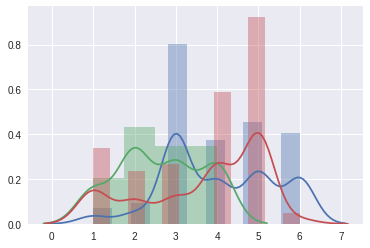

In [37]:
#Subject and scan distribution 
for cohort in ['ADNI1','ADNIGO','ADNI2']:
    sub_ids = ct_data_combined[ct_data_combined['ORIGPROT']==cohort]['PTID'].values    
    sub_counter = Counter(list(sub_ids))
    print 'cohort {}, subx:{}, scanx:{}'.format(cohort,len(sub_counter), np.sum(sub_counter.values()))
    sns.distplot(sub_counter.values())
    


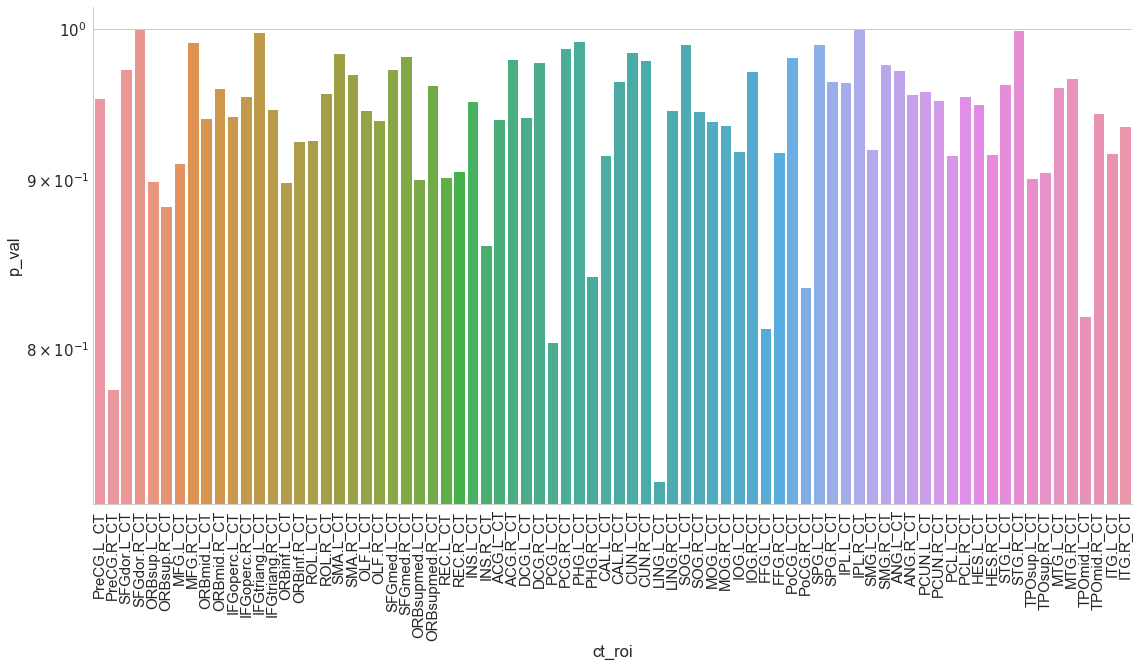

In [402]:
# Sanity check with common scans from previous run and new run (They should be same CT vals)
prev_civet = prev_ct_data[prev_ct_data['ImageUID'].isin(common_ids)][['ImageUID'] + ct_feat]
prev_civet.columns = [['ImageUID'] +roi_list] #Rename CT columns

new_civet = adni2_ct_data[adni2_ct_data['ImageUID'].isin(common_ids)][['ImageUID'] + ct_cols]

prev_civet_melt = pd.melt(prev_civet,id_vars='ImageUID',value_vars=roi_list,var_name='ROI', value_name='CT')
prev_civet_melt['when'] = list(np.tile('prev', len(prev_civet_melt)))

new_civet_melt = pd.melt(new_civet[['ImageUID'] +roi_list],id_vars='ImageUID',value_vars=roi_list,var_name='ROI', value_name='CT')
new_civet_melt['when'] = list(np.tile('new', len(new_civet_melt)))

#concat ct_data_1 and ct_data_2
ct_data_concat = pd.concat([prev_civet_melt,new_civet_melt])

# sns.set_style("whitegrid")    
# g1 = sns.factorplot(y='CT',x='ROI',kind='bar', hue='when', data=ct_data_concat,size=8, aspect=2)
# g1.set_xticklabels(rotation=90)   

ttest_df = get_significance(prev_civet,new_civet,roi_list)    
g3 = sns.factorplot(y='p_val',x='ct_roi',kind='bar',data=ttest_df,size=8, aspect=2)
g3.set_xticklabels(rotation=90)
g3.fig.get_axes()[0].set_yscale('log')  

* **Create subject master-table** 
    1. Baseline demographics 
    2. Timepoint columns with links to scans and clinical scores
    


In [57]:
#Populate master_sub_table with timepoint ImageUIDs that link to master_scan_table for CT and CS values
def populate_timepoints(master_sub_df,master_scan_df):
    for sub_id in list(master_sub_df['PTID'].values):    
        master_df_idx = master_sub_df[master_sub_df['PTID']==sub_id].index[0]
        sub_df = master_scan_df[master_scan_df['PTID']==sub_id]
        avail_tps = list(sub_df['VISCODE'].values)
        for tp in avail_tps:        
            master_sub_df.loc[master_df_idx,tp] = sub_df[sub_df['VISCODE']==tp]['ImageUID'].values

    return master_sub_df
    
def create_exp_setup(master_sub_df,master_scan_df,cohorts,timepoints,roi_list,cs_list):
    #mr and cs timepoints need not be same. 
    #mr will at most have 2 timepoints (variable duration)
    #mr_tps options: [bl,m12] (any two fixed tps) or [bl + latest available tp]
    
    cohort_df = master_sub_df[master_sub_df['ORIGPROT'].isin(cohorts)]
                              
    cs_mr_df_concat = pd.DataFrame(columns=['PTID','AGE','APOE4','PTGENDER','DX_bl'])
    ptids = cohort_df['PTID'].values
    cs_mr_df_concat = cohort_df[['PTID','AGE','APOE4','PTGENDER','DX_bl']]
    
    
    print 'total subx:{} in cohort:{}'.format(len(ptids),cohort)
    
    if len(timepoints) <= 2:      
        print 'fixed timepoint selection'
        for tp in timepoints:            
            iids = list(cohort_df[tp].values)
            print 'number of {} subx {}'.format(tp,len(list(master_scan_df[master_scan_df['ImageUID'].isin(iids)]['PTID'])))            
            
            cs_mr_df = master_scan_df[master_scan_df['ImageUID'].isin(iids)][['PTID']+roi_list+cs_list]                        
            feat_list_tp = ['{}_{}'.format(a, tp) for a in roi_list+cs_list]
            cs_mr_df.columns = ['PTID'] + feat_list_tp            
            cs_mr_df_concat = cs_mr_df_concat.merge(cs_mr_df, on='PTID')
            print 'number of {} subx {} for cs_mr'.format(tp,len(cs_mr_df_concat)) 
                        
                            
    else:
        ## Pick the latest scan (e.g. m12 > m06)
        print 'variable timepoint selection'
        
        # Check first tp == 'bl
        if timepoints[0]!='bl':
            print 'first tp needs to be *bl*'
            
        else:        
            #create bl df
            iids_bl = list(cohort_df['bl'].values)            
            cs_mr_df = master_scan_df[master_scan_df['ImageUID'].isin(iids_bl)][['PTID']+roi_list+cs_list]
            feat_list_bl = ['{}_{}'.format(a, 'bl') for a in roi_list+cs_list]
            cs_mr_df.columns = ['PTID'] + feat_list_bl         
            cs_mr_df_concat = cs_mr_df_concat.merge(cs_mr_df, on='PTID')
            print 'number of bl subx {} for mr'.format(len(cs_mr_df_concat))                         

            #Check all available tps for scans        
            feat_list_tp = ['{}_{}'.format(a, 'var_tp') for a in roi_list+cs_list]
            cs_mr_df_tp = pd.DataFrame(columns=['PTID','tp'] + feat_list_tp)            

            ptids_needing_tp = set(ptids)
            for tp in timepoints[1:]: #ignore first tp
                tp_ptids = set(master_sub_df[~master_sub_df[tp].isnull()]['PTID'].values)            
                ptid_matches = ptids_needing_tp.intersection(tp_ptids) #look for matches in the next timepoint 
                ptids_needing_tp = ptids_needing_tp - ptid_matches
                print 'tp: {}, ptids with scans:{}, ptid_tp_matches:{}, ptids still needing tp: {}'.format(tp,len(tp_ptids),
                                                                                                           len(ptid_matches),
                                                                                                           len(ptids_needing_tp))
                iids_tp = list(cohort_df[cohort_df['PTID'].isin(ptid_matches)][tp].values)
                tp_df = master_scan_df[master_scan_df['ImageUID'].isin(iids_tp)][['PTID']+roi_list+cs_list]
                tp_df.columns = ['PTID']+feat_list_tp
                tp_df['tp'] = tp                
                cs_mr_df_tp = cs_mr_df_tp.append(tp_df)

            print 'number of var_tp subx {} for mr'.format(len(cs_mr_df_tp))
            cs_mr_df_concat = cs_mr_df_concat.merge(cs_mr_df_tp, on='PTID')
            print 'number of subx bl+tp {} for mr'.format(len(cs_mr_df_concat))            
        
    ######################    
#     #collect CS timepoints
#     for tp in cs_tps:            
#         iids = list(master_sub_df[master_sub_df['ORIGPROT']==cohort][tp].values)
#         cs_df = master_scan_df[master_scan_df['ImageUID'].isin(iids)][['PTID']+cs_list]
#         cs_list_tp = ['{}_{}'.format(a, tp) for a in cs_list]
#         cs_df.columns = ['PTID'] + cs_list_tp
#         #mr_df_concat = pd.concat([mr_df_concat,mr_df],axis=1,join_axes=[mr_df_concat['PTID']])
#         cs_df_concat = cs_df_concat.merge(cs_df, on='PTID')
#         print 'number of {} subx {} for cs'.format(tp,len(cs_df_concat))
    
    #clean to remove NaN rows.
    print ''
    cs_mr_df_concat.dropna(inplace=True)            
    print 'number of concat (NaN dropped) subx: {}'.format(len(cs_mr_df_concat))
    
    return cs_mr_df_concat
    

In [40]:
bl_demo_cols = ['PTID','ORIGPROT','COLPROT','MagStrength','AGE','PTGENDER','APOE4','DX_bl']
subx_master_table = ct_data_combined[bl_demo_cols]

print 'subx:{}'.format(len(subx_master_table))
subx_master_table = subx_master_table.drop_duplicates(['PTID'], keep='first')
print 'After dup drop, subx:{}'.format(len(subx_master_table))

#Drop subjects used to create trajectory templates from this analysis
template_sub_file ='/projects/nbhagwat/Traj_prediction/ADNI/exp_setup/ADNI1_trajectory_template_train_set.csv'
template_subs = list(pd.read_csv(template_sub_file)['PTID'].values)
subx_master_table = subx_master_table[~subx_master_table['PTID'].isin(template_subs)]
print 'After template_sub drop, subx:{}'.format(len(subx_master_table))

subx_master_table = populate_timepoints(subx_master_table,ct_data_combined)

subx:5713
After dup drop, subx:1521
After template_sub drop, subx:1450


In [61]:
#Generate experimental dataframe with specific cohort and timepoint(s)
save_df = False

cohorts = ['ADNIGO','ADNI1','ADNI2']
timepoints = ['bl','m12','m06','m03']

cs_list = ['MMSE','ADAS13']
cs_mr_df_concat = create_exp_setup(subx_master_table,ct_data_combined,cohorts,timepoints,roi_list,cs_list)

if len(timepoints) > 2:
    #Create delta(CT)/delta(t_months)    
    cs_mr_df_concat = cs_mr_df_concat.replace({'m12':12,'m06':6,'m03':3})
    print 'Appending delta(CT)/delta(t) columns'
    for col in roi_list:
        cs_mr_df_concat[col+'_rate'] = (cs_mr_df_concat[col+'_var_tp'] - cs_mr_df_concat[col+'_bl'])/(cs_mr_df_concat['tp'])

print 'number of featx (including 5 demo and cs features): {}'.format(len(cs_mr_df_concat.columns))
#Save MR df (you can also save CS df, but not necessary for trajectory prediction)
if save_df:
    cs_mr_df_concat.to_csv('/projects/nbhagwat/Traj_prediction/ADNI/exp_setup/{}_var_tp.csv'.format('ALL_ADNI'))

total subx:1450 in cohort:ADNIGO
variable timepoint selection
number of bl subx 1400 for mr
tp: m12, ptids with scans:1164, ptid_tp_matches:1164, ptids still needing tp: 286
tp: m06, ptids with scans:1059, ptid_tp_matches:68, ptids still needing tp: 218
tp: m03, ptids with scans:603, ptid_tp_matches:69, ptids still needing tp: 149
number of var_tp subx 1301 for mr
number of subx bl+tp 1261 for mr

number of concat (NaN dropped) subx: 1176
Appending delta(CT)/delta(t) columns
number of featx (including 5 demo and cs features): 244


In [37]:
cs_mr_df_concat[cs_mr_df_concat.PTID=='003_S_4373'][['PTID','AGE','PTGENDER','APOE4','DX_bl','MMSE_bl','MMSE_var_tp']] #003_S_4373

,PTID,AGE,PTGENDER,APOE4,DX_bl,MMSE_bl,MMSE_var_tp
25,003_S_4373,71.1,Female,1.0,AD,20.0,4.0


In [24]:
subx_master_table[subx_master_table.PTID=='003_S_4373']

,PTID,ORIGPROT,COLPROT,MagStrength,AGE,PTGENDER,APOE4,DX_bl,m06,m24,m36,bl,m12,m18,m03,m48
6667,003_S_4373,ADNI2,ADNI2,3.0,71.1,Female,1.0,AD,392154.0,NaN,NaN,278134.0,NaN,NaN,NaN,NaN


In [ ]:
###OLDER CODE####
Atlas_type = 'AAL'
#use top 40,962 to match low-res subjects http://www.bic.mni.mcgill.ca/ServicesSoftware/StatisticalAnalysesUsingSurfstatMatlab

#Regex for parsing PTID and IID 
ptid_re = re.compile('\d*(_S_)\d*')
iid_re = re.compile('\d*(_I)\d*')

# Read atlas files
if Atlas_type == 'AAL':
    atlas_file_L = '/projects/nikhil/ADNI_prediction/input_datasets/CT/AAL/AAL_atlas_left.txt'
    atlas_file_R = '/projects/nikhil/ADNI_prediction/input_datasets/CT/AAL/AAL_atlas_right.txt'
    with open(atlas_file_L) as f:
        atlas_data_highRes_L = f.readlines()

    with open(atlas_file_R) as f:
        atlas_data_highRes_R = f.readlines()
    
    atlas_data_list = atlas_data_highRes_L[:40962] + atlas_data_highRes_R[:40962]
    atlas_data = np.array(atlas_data_list,dtype=int)
        
else:        
    atlas_file_L = '/projects/nikhil/ADNI_prediction/input_datasets/CT/left-labels_C375.txt'
    #Use same atlas for L & R to preseve symmetry to ROIs
    atlas_file_R = '/projects/nikhil/ADNI_prediction/input_datasets/CT/right-labels_C375.txt'

    atlas_data_L = np.genfromtxt(atlas_file_L, dtype=int)
    atlas_data_R = 1000 + np.genfromtxt(atlas_file_R, dtype=int)#adding big enough offset to sperate L v R ROIs
    
    atlas_data = np.hstack((atlas_data_L[:40962],atlas_data_R[:40962]))
    atlas_data_list = list(atlas_data)
        
unique_roi = np.array(list(set(atlas_data)))


print 'atlas data (number of L + R vertices) {}'.format(len(atlas_data))
print '# of unique ROIs {}'.format(len(unique_roi))

In [43]:
from collections import Counter
print atlas_data_L.shape
roi_count_L = Counter(atlas_data_L)
roi_count_R = Counter(atlas_data_R)

print np.sort(roi_count_L.values())
print ""
print np.sort(roi_count_R.values())



(40963,)
[   1   68   70   74   75   76   76   76   77   77   77   77   77   78   78
   78   78   79   80   80   80   80   80   81   82   82   83   84   84   85
   86   88   88   92   92   92   94   94   94   97   97   97   97   97   97
   98   98   98   98   98   98   98   98   99   99   99   99  100  100  100
  100  100  100  101  101  101  101  101  101  101  101  101  101  102  102
  102  102  102  103  103  103  103  103  103  104  104  104  104  104  104
  104  104  105  105  105  105  105  105  105  105  105  105  106  106  106
  106  106  106  106  106  106  106  106  106  107  107  107  107  107  107
  107  107  107  107  107  107  107  107  107  107  108  108  108  108  108
  108  108  108  109  109  109  109  109  109  109  109  109  109  109  109
  109  109  109  109  110  110  110  110  110  110  110  110  110  110  110
  110  110  110  110  110  110  110  110  110  110  111  111  111  111  111
  111  111  111  111  111  111  111  111  111  111  111  112  112  112  112
  1

In [26]:
# Grab left and right CT data for a given subject
def get_baseline_data(baseline_dir):
    print "nothing to do yet.. need to find mean thickness values from civet"
        
    
def get_legacy_SubjectData(civet_out_dir,sub_id):
    
    subject_file_L = civet_out_dir + sub_id + '_left.txt'
    subject_file_R = civet_out_dir + sub_id + '_right.txt'
    
    if os.path.isfile(subject_file_L) and os.path.isfile(subject_file_R):
    
        with open(subject_file_L) as f:
            subject_data_list_L = f.readlines()

        with open(subject_file_R) as f:
            subject_data_list_R = f.readlines()

        subject_data = np.array(subject_data_list_L + subject_data_list_R,dtype=float)
        msg = True
            
    else:        
        subject_data = 0
        msg = False
        
    return {'subject_data':subject_data, 'success': msg}

def get_ADNI_SubjectData(civet_out_dir,sub_id, prefix):
    sub_pre = sub_id + '/thickness/{}_'.format(prefix)
    sub_suf_L = '_native_rms_rsl_tlink_28.28mm_left.txt'
    sub_suf_R = '_native_rms_rsl_tlink_28.28mm_right.txt'
    
    subject_file_L = civet_out_dir + sub_pre + sub_id + sub_suf_L
    subject_file_R = civet_out_dir + sub_pre + sub_id + sub_suf_R
    
    if os.path.isfile(subject_file_L) and os.path.isfile(subject_file_R):
    
        with open(subject_file_L) as f:
            subject_data_list_L = f.readlines()

        with open(subject_file_R) as f:
            subject_data_list_R = f.readlines()

        subject_data = np.array(subject_data_list_L + subject_data_list_R,dtype=float)
        msg = True
            
    else:        
        subject_data = 0
        msg = False
        
    return {'subject_data':subject_data, 'success': msg}

# Create dictionary with roi_id:[thickness values]
def get_ROI_CT_dict(unique_roi, atlas_data, subject_data):
    roi_CT_dict = collections.defaultdict(list)
    for roi in unique_roi:
        roi_idx = atlas_data==roi
        roi_CT_dict[roi].append(subject_data[roi_idx])
        #print str(roi) + ': ' +  str(np.sum(roi_idx))    
        
    return roi_CT_dict

def save_dictionary(_dict,save_path):
    f = open(save_path, 'wb')
    pickle.dump(_dict, f)
    f.close()

In [ ]:
len(subject_ROI_CT_dict[ptid][0])

In [8]:
# ADNI CT imports
prefix = 'ADNI'
subject_ROI_CT_dict_filename = baseline_dir + 'ADNI2_subject_ROI_CT_dict.pkl'
subject_dirs_path = '/mnt/tigrlab/scratch/nikhil/ADNI2/civet_out/'
subject_dirs = os.listdir(subject_dirs_path)
#Dictionary of dictionary --> subject:{roi:CT_vals}
subject_ROI_CT_dict = collections.defaultdict(list)
subs_missing_data  = []
for sub_dir in subject_dirs:
    if sub_dir.split("_")[0] == 'ADNI':
        ptid = re.search(ptid_re, sub_dir).group(0).strip()
        #print ptid
        result = get_ADNI_SubjectData(subject_dirs_path,sub_dir,prefix)

        # check if subject data exists
        if result['success']:
            single_ROI_CT_dict = get_ROI_CT_dict(unique_roi,result['subject_data'])
            if len(single_ROI_CT_dict) != len(unique_roi):
                print "something is wrong"
                print sub_dir
            subject_ROI_CT_dict[ptid].append(single_ROI_CT_dict)
        else:
            subs_missing_data.append(ptid) 
            
    else:
        print 'Not an ADNI dir: {}'.format(sub_dir)

print 'missing data for subjects: {}'.format(len(subs_missing_data))

missing data for subjects: 11290


In [ ]:
# keep log of subs with missing data:
sub_missing_data_file = '/projects/nikhil/ADNI_prediction/input_datasets/CT/civet_out/adni1/bad_subs'
with open(sub_missing_data_file, 'w') as f:
    for s in subs_missing_data:
        f.write(s + '\n')
        
print len(subs_missing_data)


In [36]:
len(subject_ROI_CT_dict)*2

11290

In [30]:
# ADNI-1 CT imports (legacy)
# Grab all the subject idx
civet_out_dir = '/data/chamal/projects/raihaan/adni2-juneprocessing/civet-out/thickness/'
subject_files = os.listdir(baseline_dir)
subject_idx = []
for sub in subject_files:
    idx = sub.rsplit('.',1)[0].rsplit('_',1)[0] #get rid .txt and lists         
    subject_idx.append(idx)

print len(subject_idx)

11290


In [33]:
# ADNI-1 CT imports (legacy)
# Generate dictionary
#Dictionary of dictionary --> subject:{roi:CT_vals}
subject_ROI_CT_dict = collections.defaultdict(list)
subs_missing_data  = []
for sub_id in list(set(subject_idx)):
    result = get_legacy_SubjectData(civet_out_dir,sub_id)    
    # check if subject data exists
    if result['success']:
        single_ROI_CT_dict = get_ROI_CT_dict(unique_roi,atlas_data,result['subject_data'])
        subject_ROI_CT_dict[sub_id].append(single_ROI_CT_dict)
    else:
        subs_missing_data.append(sub_id)

In [ ]:
#Chech if all ADNI-1 subjects have ROI-CT dataset assoicated with them
master_dataframe = '/projects/francisco/data/ADNI/master_fused.pkl'
data = pd.read_pickle(master_dataframe)
id_image = re.compile('(?<=I)\d*')
ADNI1_subs_with_CT_data = []
for uid in data.UID:
    img = re.search(ptid_re, uid).group(0)
    if img in subject_ROI_CT_dict.keys():
        if len(subject_ROI_CT_dict[img][0]) == len(unique_roi): #688 for spectral clustering, #79 for AAL
             ADNI1_subs_with_CT_data.append(img)    
        
        
print len(ADNI1_subs_with_CT_data), len(subject_ROI_CT_dict)

In [37]:
#Check the minimun number of vertices per ROI (=min sampling bound = 132 for ADNI1 baseline)
no_of_vertices = []
for key in single_ROI_CT_dict.keys():
    no_of_vertices.append(len(single_ROI_CT_dict[int(key)][0]))
    
print np.asarray(no_of_vertices).min()     

132


In [121]:
# Creat CSV with PTID, ImageID, and mean CT per ROI 
AAL_roi_list = []
for r in unique_roi:
    AAL_roi_list.append('AAL_' + str(r))
    
CT_AAL_list = []
col_header = ['AAL_PTID','ImageUID'] + AAL_roi_list
CT_AAL_list.append(col_header)
for idx, sub in enumerate(subject_ROI_CT_dict):
    ptid = re.search(ptid_re, sub).group(0).strip()
    iid = re.search(iid_re, sub).group(0).strip().split('I')[1]
    subject_roi_CT_list = []
    for key, val in subject_ROI_CT_dict[sub][0].iteritems():
        subject_roi_CT_list.append(np.mean(np.array(val)))
    
    CT_AAL_list.append([ptid,iid] + subject_roi_CT_list)




In [190]:
from sklearn.decomposition import PCA
X = np.random.random((10,100)) - 0.5
print 'mean,std X: {},{}'.format(np.mean(X),np.std(X))
pca = PCA(n_components=100)
pca.fit(X)
X2 = pca.transform(X)
print X2.shape
print 'mean,std X2: {},{}'.format(np.mean(X2),np.std(X2))

mean,std X: 0.00909889339256,0.279755410388
(10, 10)
mean,std X2: 8.29197821517e-18,0.842401578855


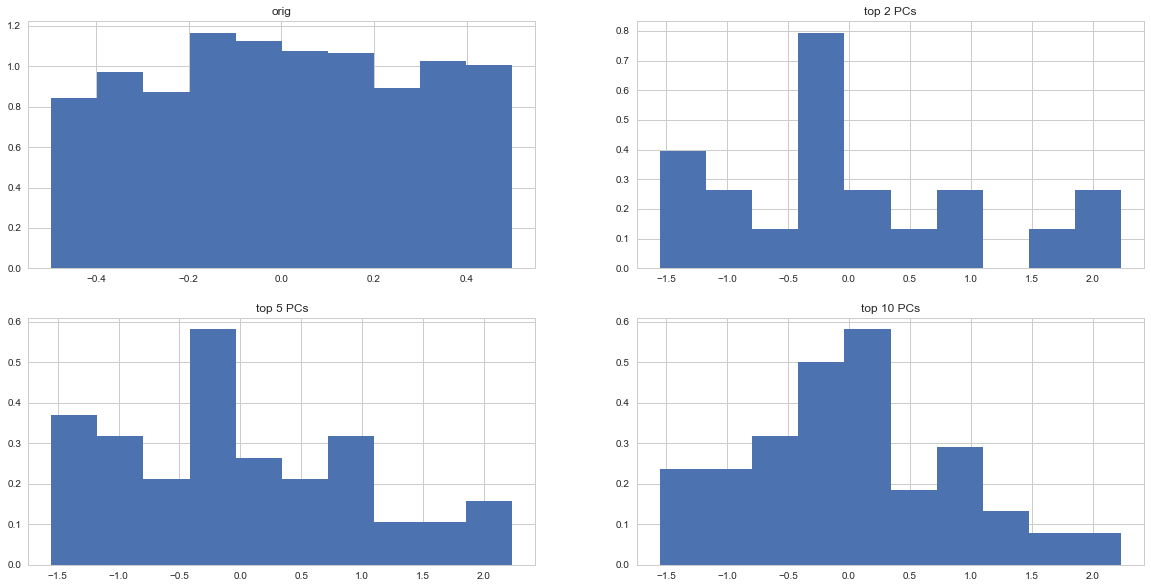

In [191]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.subplot(2,2,1)
plt.hist(X.flatten(),normed=True)
plt.title('orig')
plt.subplot(2,2,2)
plt.hist(X2[:,:2].flatten(),normed=True)
plt.title('top 2 PCs')
plt.subplot(2,2,3)
plt.hist(X2[:,:5].flatten(),normed=True)
plt.title('top 5 PCs')
plt.subplot(2,2,4)
plt.hist(X2[:,:10].flatten(),normed=True)
plt.title('top 10 PCs')

In [193]:
a,b=np.histogram(X.flatten(),normed=False)
print np.sum(a), np.sum(b)
a,b=np.histogram(X2[:,:2].flatten(),normed=False)
print np.sum(a), np.sum(b)
a,b=np.histogram(X2.flatten(),normed=False)
print np.sum(a), np.sum(b)

1000 0.0124065375178
20 3.74896320787
100 3.74233695696


In [30]:
subx_master_table

,PTID,ORIGPROT,COLPROT,MagStrength,AGE,PTGENDER,DX_bl,m06,m24,m36,bl,m12,m18,m03,m48
4721,002_S_0295,ADNI1,ADNI1,1.5,84.8,Male,CN,118692.0,123685.0,150177.0,241351.0,308079.0,NaN,NaN,NaN
1189,002_S_0413,ADNI1,ADNI1,3.0,76.3,Female,CN,NaN,373189.0,424742.0,242896.0,312703.0,NaN,NaN,NaN
4731,002_S_0619,ADNI1,ADNI1,1.5,77.5,Male,AD,60451.0,120964.0,NaN,118678.0,67871.0,NaN,NaN,NaN
4740,002_S_0685,ADNI1,ADNI1,1.5,89.6,Female,CN,86020.0,120994.0,161974.0,300265.0,326603.0,NaN,NaN,NaN
4749,002_S_0782,ADNI1,ADNI1,1.5,81.6,Male,LMCI,60456.0,124718.0,162978.0,118669.0,87283.0,112184.0,NaN,NaN
4756,002_S_0938,ADNI1,ADNI1,1.5,82.2,Female,AD,60030.0,125155.0,NaN,118685.0,81312.0,NaN,NaN,NaN
4759,002_S_1018,ADNI1,ADNI1,1.5,70.7,Female,AD,73016.0,132197.0,NaN,40817.0,87204.0,NaN,NaN,NaN
4763,002_S_1070,ADNI1,ADNI1,1.5,73.6,Male,LMCI,60478.0,132206.0,165275.0,40831.0,86304.0,121072.0,NaN,NaN
4771,002_S_1261,ADNI1,ADNI1,1.5,71.1,Female,CN,79126.0,418842.0,500243.0,296428.0,362928.0,NaN,NaN,NaN
4782,002_S_1280,ADNI1,ADNI1,1.5,70.7,Female,CN,81321.0,419623.0,171124.0,290930.0,362930.0,NaN,NaN,NaN


In [41]:
print len(subx_master_table)
ptids = set(subx_master_table['PTID'].values)
bl_ptids = set(subx_master_table[~subx_master_table['bl'].isnull()]['PTID'].values)
m06_ptids = set(subx_master_table[~subx_master_table['m06'].isnull()]['PTID'].values)
m12_ptids = set(subx_master_table[~subx_master_table['m12'].isnull()]['PTID'].values)

m12_matches = bl_ptids.intersection(m12_ptids)
missing_m12_ptids = bl_ptids - m12_matches
m06_matches = m06_ptids.intersection(missing_m12_ptids)
missing_m06_ptids = missing_m12_ptids - m06_matches

print len(ptids), len(bl_ptids), len(m12_ptids), len(m06_ptids)
print len(m12_matches), len(missing_m12_ptids)
print len(m06_matches), len(missing_m06_ptids)

1249
1249 1198 952 828
923 275
56 219
